# Benchmarks analysis

This notebook aims to assess our model's performances on two synthetic benchkmarks of abnormalities:
- deletion benchmark: simple surfaces of various sizes have been randomly deleted
- asymmetry benchmark: equivalent crop but on left hemisphere and then flipped

In [2]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import SkeletonDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [3]:
if torch.cuda.is_available():
    device = "cuda:0"

In [4]:
model_dir = '/neurospin/dico/lguillon/distmap/gridsearch_lr5e-4/n_75_kl_2/checkpoint.pt'
model = VAE((1, 80, 80, 96), 75, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

In [5]:
data_dir = "/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/"
df_encoded_hcp = pd.read_pickle(os.path.join(data_dir, "encoded_hcp.pkl"))

### Loading of deletion benchmark

In [6]:
data_dir = "/neurospin/dico/lguillon/distmap/benchmark/deletion"
data_path = "crops/1mm/SC"

In [7]:
distmaps_200 = np.load(os.path.join(data_dir, "200", data_path, "200_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_200 = np.load(os.path.join(data_dir, "200", data_path, "sub_id.npy"))

subset_200 = SkeletonDataset(dataframe=distmaps_200,
                         filenames=filenames_200,
                         data_transforms=False)
loader_200 = torch.utils.data.DataLoader(
               subset_200,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_500 = np.load(os.path.join(data_dir, "500", data_path, "500_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_500 = np.load(os.path.join(data_dir, "500", data_path, "sub_id.npy"))

subset_500 = SkeletonDataset(dataframe=distmaps_500,
                         filenames=filenames_500,
                         data_transforms=False)
loader_500 = torch.utils.data.DataLoader(
               subset_500,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_700 = np.load(os.path.join(data_dir, "700", data_path, "700_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_700 = np.load(os.path.join(data_dir, "700", data_path, "sub_id.npy"))

subset_700 = SkeletonDataset(dataframe=distmaps_700,
                         filenames=filenames_700,
                         data_transforms=False)
loader_700 = torch.utils.data.DataLoader(
               subset_700,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_1000 = np.load(os.path.join(data_dir, "1000", data_path, "1000_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_1000 = np.load(os.path.join(data_dir, "1000", data_path, "sub_id.npy"))

subset_1000 = SkeletonDataset(dataframe=distmaps_1000,
                         filenames=filenames_1000,
                         data_transforms=False)
loader_1000 = torch.utils.data.DataLoader(
               subset_1000,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [8]:
dico_set_loaders = {'200': loader_200, '500': loader_500, '700': loader_700, '1000': loader_1000}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

criterion = nn.MSELoss(reduction='sum')
tester_deletion = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_deletion = tester_deletion.test()
encoded_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[int(results_deletion[loader_name][k][0].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[int(results_deletion[loader_name][k][2].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_deletion = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

200
[0.0000000e+00 1.7642975e-05 2.4557114e-05 ... 9.9955142e-01 9.9978638e-01
 9.9981844e-01]
[0.0000000e+00 2.4127960e-04 2.4199486e-04 ... 9.9941254e-01 9.9962616e-01
 9.9975431e-01]
[0.0000000e+00 7.6770782e-05 7.7486038e-05 ... 9.9918818e-01 9.9940193e-01
 9.9992526e-01]
[0.0000000e+00 8.1062317e-06 1.0251999e-05 ... 9.9878240e-01 9.9950385e-01
 9.9991226e-01]
[0.0000000e+00 1.5497208e-05 1.7642975e-05 ... 9.9899602e-01 9.9912417e-01
 9.9957907e-01]
[0.0000000e+00 2.1457672e-05 2.2649765e-05 ... 9.9948692e-01 9.9963152e-01
 9.9969029e-01]
[0.0000000e+00 1.2850761e-04 1.5640259e-04 ... 9.9943388e-01 9.9957812e-01
 9.9986112e-01]
[0.0000000e+00 5.3167343e-05 6.1511993e-05 ... 9.9889457e-01 9.9904931e-01
 9.9919891e-01]
[0.0000000e+00 3.3712387e-04 3.5011768e-04 ... 9.9930573e-01 9.9981844e-01
 9.9988246e-01]
[0.0000000e+00 2.3126602e-05 2.4080276e-05 ... 9.9839783e-01 9.9889481e-01
 9.9987185e-01]
[0.0000000e+00 2.1934509e-05 2.4080276e-05 ... 9.9927366e-01 9.9936450e-01
 9.9996257e

[0.00000000e+00 1.20162964e-04 1.25646591e-04 ... 9.99433875e-01
 9.99465942e-01 9.99839783e-01]
[0.0000000e+00 7.6055527e-05 8.2969666e-05 ... 9.9935913e-01 9.9942851e-01
 9.9949801e-01]
[0.0000000e+00 3.3140182e-05 4.5061111e-05 ... 9.9899685e-01 9.9936986e-01
 9.9965823e-01]
[0.0000000e+00 8.4161758e-05 8.8214874e-05 ... 9.9965823e-01 9.9990392e-01
 9.9999464e-01]
[0.0000000e+00 1.6355515e-04 1.6498566e-04 ... 9.9891591e-01 9.9903870e-01
 9.9959409e-01]
[0.0000000e+00 7.4625015e-05 7.9631805e-05 ... 9.9891591e-01 9.9915624e-01
 9.9944985e-01]
[0.0000000e+00 4.0054321e-05 4.2915344e-05 ... 9.9922025e-01 9.9943388e-01
 9.9956203e-01]
[0.0000000e+00 5.1736832e-05 5.2452087e-05 ... 9.9933779e-01 9.9946594e-01
 9.9975431e-01]
[0.0000000e+00 2.0265579e-05 2.0742416e-05 ... 9.9955666e-01 9.9959409e-01
 9.9976504e-01]
[0.0000000e+00 1.2826920e-04 1.4472008e-04 ... 9.9938583e-01 9.9959946e-01
 9.9971163e-01]
[0.0000000e+00 3.7670135e-05 4.7445297e-05 ... 9.9830174e-01 9.9861145e-01
 9.992042

[0.0000000e+00 1.6212463e-05 1.7642975e-05 ... 9.9885714e-01 9.9947667e-01
 9.9992526e-01]
[0.0000000e+00 1.7404556e-05 1.8119812e-05 ... 9.9933779e-01 9.9946070e-01
 9.9995029e-01]
[0.0000000e+00 5.0067902e-06 6.1988831e-06 ... 9.9937522e-01 9.9970090e-01
 9.9987185e-01]
[0.0000000e+00 5.1259995e-05 5.2213669e-05 ... 9.9941254e-01 9.9965501e-01
 9.9996793e-01]
[0.0000000e+00 9.2267990e-05 1.0108948e-04 ... 9.9902797e-01 9.9973297e-01
 9.9979174e-01]
[0.0000000e+00 2.1219254e-05 2.1457672e-05 ... 9.9781036e-01 9.9838746e-01
 9.9889982e-01]
[0.0000000e+00 4.1007996e-05 4.3153763e-05 ... 9.9927366e-01 9.9944460e-01
 9.9989319e-01]
[0.0000000e+00 3.9339066e-05 4.1723251e-05 ... 9.9856639e-01 9.9872887e-01
 9.9962616e-01]
[0.0000000e+00 2.8133392e-05 2.8610229e-05 ... 9.9756467e-01 9.9951935e-01
 9.9972224e-01]
[0.0000000e+00 2.1219254e-05 2.2649765e-05 ... 9.9904406e-01 9.9925768e-01
 9.9982917e-01]
[0.0000000e+00 5.8889389e-05 6.4373016e-05 ... 9.9911880e-01 9.9917758e-01
 9.9938047e-01]

[0.0000000e+00 4.7683716e-06 5.2452087e-06 ... 9.9836040e-01 9.9872887e-01
 9.9962616e-01]
[0.0000000e+00 6.4373016e-06 8.1062317e-06 ... 9.9871826e-01 9.9951935e-01
 9.9954069e-01]
[0.0000000e+00 9.5367432e-07 1.1920929e-06 ... 9.9581301e-01 9.9759674e-01
 9.9958885e-01]
[0.0000000e+00 6.4373016e-06 6.6757202e-06 ... 9.9763942e-01 9.9856877e-01
 9.9924159e-01]
[0.0000000e+00 4.4107437e-05 4.7445297e-05 ... 9.9755931e-01 9.9774623e-01
 9.9962080e-01]
[0.0000000e+00 3.0994415e-06 4.2915344e-06 ... 9.9941254e-01 9.9965823e-01
 9.9974895e-01]
[0.0000000e+00 3.6001205e-05 3.7193298e-05 ... 9.9899602e-01 9.9943388e-01
 9.9950337e-01]
[0.0000000e+00 1.6689301e-06 1.9073486e-06 ... 9.9777424e-01 9.9779022e-01
 9.9957204e-01]
[0.0000000e+00 2.8848648e-05 2.9087067e-05 ... 9.9814153e-01 9.9900663e-01
 9.9966359e-01]
[0.0000000e+00 3.6954880e-05 4.1484833e-05 ... 9.9911880e-01 9.9938047e-01
 9.9947667e-01]
[0.0000000e+00 2.1219254e-05 2.2172928e-05 ... 9.9885714e-01 9.9966359e-01
 9.9982917e-01]

[0.0000000e+00 2.3841858e-07 4.7683716e-07 ... 9.9839783e-01 9.9889481e-01
 9.9987185e-01]
[0.0000000e+00 2.1934509e-05 2.4080276e-05 ... 9.9927366e-01 9.9936450e-01
 9.9996257e-01]
[0.0000000e+00 4.7683716e-07 7.1525574e-07 ... 9.9946594e-01 9.9947667e-01
 9.9992526e-01]
[0.0000000e+00 7.1525574e-07 9.5367432e-07 ... 9.9758077e-01 9.9764490e-01
 9.9862218e-01]
[0.0000000e+00 7.1525574e-06 7.6293945e-06 ... 9.9912417e-01 9.9919891e-01
 9.9953008e-01]
[0.0000000e+00 2.3841858e-07 4.7683716e-07 ... 9.9481964e-01 9.9532163e-01
 9.9994659e-01]
[0.0000000e+00 4.0531158e-06 4.2915344e-06 ... 9.9814677e-01 9.9929190e-01
 9.9946070e-01]
[0.0000000e+00 1.1205673e-05 1.2397766e-05 ... 9.9828029e-01 9.9905479e-01
 9.9967027e-01]
[0.0000000e+00 4.0531158e-06 4.5299530e-06 ... 9.9954605e-01 9.9973297e-01
 9.9987185e-01]
[0.0000000e+00 1.1920929e-06 1.4305115e-06 ... 9.9878240e-01 9.9923635e-01
 9.9957275e-01]
[0.0000000e+00 1.9073486e-06 2.1457672e-06 ... 9.9977577e-01 9.9994659e-01
 9.9994743e-01]

[0.0000000e+00 9.5367432e-07 1.4305115e-06 ... 9.9845123e-01 9.9901199e-01
 9.9951935e-01]
[0.0000000e+00 1.4305115e-06 1.9073486e-06 ... 9.9916685e-01 9.9967957e-01
 9.9984515e-01]
[0.0000000e+00 1.6689301e-06 2.1457672e-06 ... 9.9668884e-01 9.9811554e-01
 9.9904704e-01]
[0.0000000e+00 2.3841858e-07 4.7683716e-07 ... 9.9906003e-01 9.9922025e-01
 9.9991453e-01]
[0.0000000e+00 4.5299530e-06 5.0067902e-06 ... 9.9957812e-01 9.9970627e-01
 9.9979711e-01]
[0.0000000e+00 2.5987625e-05 3.0040741e-05 ... 9.9960482e-01 9.9972761e-01
 9.9980247e-01]
[0.0000000e+00 9.2983246e-06 1.0967255e-05 ... 9.9928439e-01 9.9938047e-01
 9.9969554e-01]
[0.0000000e+00 2.1457672e-06 2.6226044e-06 ... 9.9898529e-01 9.9919891e-01
 9.9926293e-01]
[0.0000000e+00 1.4305115e-06 1.6689301e-06 ... 9.9763942e-01 9.9795282e-01
 9.9909747e-01]
[0.0000000e+00 7.1525574e-07 9.5367432e-07 ... 9.9953008e-01 9.9980772e-01
 9.9994659e-01]
[0.0000000e+00 4.5299530e-06 5.2452087e-06 ... 9.9823761e-01 9.9825203e-01
 9.9893188e-01]

In [9]:
df_encoded_deletion = pd.DataFrame()
df_encoded_deletion['latent'] = encoded_deletion['200'] +encoded_deletion['500']+ encoded_deletion['700'] +encoded_deletion['1000']  
df_encoded_deletion['loss'] = losses_deletion['200'] + losses_deletion['500'] + losses_deletion['700'] + losses_deletion['1000'] 
df_encoded_deletion['recon'] = recon_deletion['200'] + recon_deletion['500'] +recon_deletion['700'] + recon_deletion['1000']  
df_encoded_deletion['input'] = input_deletion['200'] + input_deletion['500'] + input_deletion['700'] + input_deletion['1000']
df_encoded_deletion['sub'] = list(filenames_200) + list(filenames_500) + list(filenames_700) + list(filenames_1000)
df_encoded_deletion['group'] = ['200' for k in range(len(list(filenames_200)))] + ['500' for k in range(len(list(filenames_500)))] + ['700' for k in range(len(list(filenames_700)))] + ['1000' for k in range(len(list(filenames_1000)))]

In [10]:
deletion_200 = pd.DataFrame()
deletion_200['latent'] = encoded_deletion['200']
deletion_200['loss'] = losses_deletion['200']  
deletion_200['recon'] = recon_deletion['200']   
deletion_200['input'] = input_deletion['200'] 
deletion_200['sub'] = list(filenames_200) 

In [11]:
deletion_500 = pd.DataFrame()
deletion_500['latent'] = encoded_deletion['500']  
deletion_500['loss'] = losses_deletion['500'] 
deletion_500['recon'] = recon_deletion['500']  
deletion_500['input'] = input_deletion['500']
deletion_500['sub'] = list(filenames_500)

deletion_700 = pd.DataFrame()
deletion_700['latent'] = encoded_deletion['700']  
deletion_700['loss'] = losses_deletion['700'] 
deletion_700['recon'] = recon_deletion['700']  
deletion_700['input'] = input_deletion['700']
deletion_700['sub'] = list(filenames_700)

deletion_1000 = pd.DataFrame()
deletion_1000['latent'] = encoded_deletion['1000']  
deletion_1000['loss'] = losses_deletion['1000'] 
deletion_1000['recon'] = recon_deletion['1000']  
deletion_1000['input'] = input_deletion['1000']
deletion_1000['sub'] = list(filenames_1000)

In [11]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub')
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub')
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [12]:
len(deletion_all)

10

### Benchmark 200

In [13]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 100)
df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(list_encoded_200)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_200_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [14]:
random_ctrl = random.sample(list(df_encoded_hcp['sub'][:200]), 100)

In [15]:
random_deletion = list(set(list(deletion_200['sub'].astype(int))) - set(random_ctrl))

In [16]:
df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(random_deletion)]
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

In [17]:
X_200 = np.array(list(df_encoded_200_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_200_X['latent']))

from sklearn.manifold import TSNE
# X_embedded_200 = TSNE(n_components=2).fit_transform(X_all)
labels_200 = np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(len(df_encoded_200_X))])

In [18]:
reducer = umap.UMAP()
embedding_200 = reducer.fit_transform(X_all)

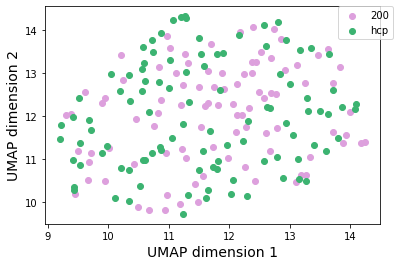

In [19]:
arr = embedding_200
color_dict = {'hcp':'mediumseagreen', '200': 'plum'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_200):
    ix = np.where(labels_200 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Benchmark 500

In [20]:
df_encoded_500_X = deletion_500

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_500['sub'].astype(int))))
random_ctrl = random.sample(list_ctrl, 100)
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

In [21]:
X_500 = np.array(list(df_encoded_500_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_500_X['latent']))

#X_embedded_500 = TSNE(n_components=2).fit_transform(X_all)
labels_500 = np.array(list(df_encoded_hcp_X['Group']) + ['500' for k in range(len(df_encoded_500_X))])
reducer = umap.UMAP()
embedding_500 = reducer.fit_transform(X_all)

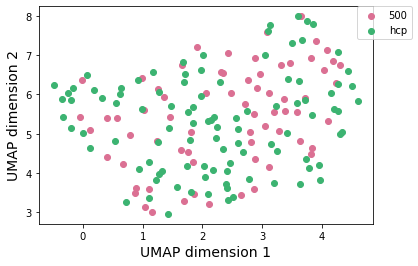

In [22]:
arr = embedding_500
color_dict = {'hcp':'mediumseagreen', '500': 'palevioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_500):
    ix = np.where(labels_500 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(0.95,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Benchmark 700

In [23]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 100)
df_encoded_700_X = deletion_700[deletion_700['sub'].astype(int).isin(list_encoded_700)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_700_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [24]:
X_700 = np.array(list(df_encoded_700_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_700_X['latent']))

#X_embedded_700 = TSNE(n_components=2).fit_transform(X_all)
labels_700 = np.array(list(df_encoded_hcp_X['Group']) + ['700' for k in range(len(df_encoded_700_X))])
reducer = umap.UMAP()
embedding_700 = reducer.fit_transform(X_all)

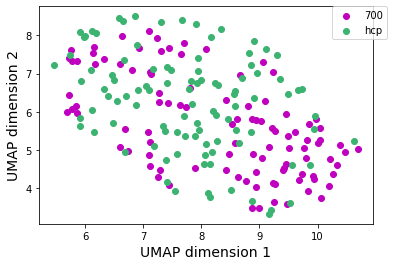

In [25]:
arr = embedding_700
color_dict = {'hcp':'mediumseagreen', '700': 'm'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_700):
    ix = np.where(labels_700 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Benchmark 1000

In [26]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 100)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].astype(int).isin(list_encoded_1000)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_1000_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [27]:
X_1000 = np.array(list(df_encoded_1000_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_1000_X['latent']))

#X_embedded_1000 = TSNE(n_components=2, perplexity=15).fit_transform(X_all)
labels_1000 = np.array(list(df_encoded_hcp_X['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])
reducer = umap.UMAP()
embedding_1000 = reducer.fit_transform(X_all)

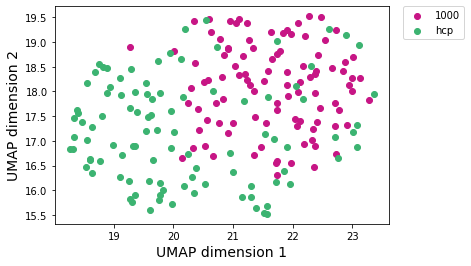

In [28]:
arr = embedding_1000
color_dict = {'hcp':'mediumseagreen', '1000': 'mediumvioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_1000):
    ix = np.where(labels_1000 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### ALL

In [634]:
X = np.array(list(df_encoded_hcp['latent']) +
             list(deletion_200['latent']) +
             list(deletion_500['latent']) +
             list(deletion_700['latent']) +
             list(deletion_1000['latent']))
labels = np.array(list(df_encoded_hcp['Group']) + 
                  ['200' for k in range(len(deletion_200))] +
                  ['500' for k in range(len(deletion_500))] +
                  ['700' for k in range(len(deletion_700))] +
                  ['1000' for k in range(len(deletion_1000))])
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X)

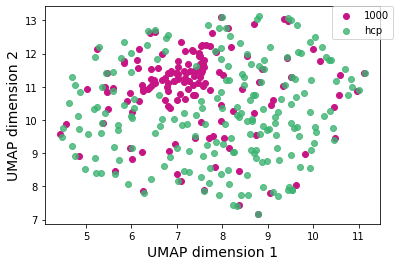

In [638]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', '200': 'plum', '500': 'palevioletred', '700': 'm', '1000': 'mediumvioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.8)
    elif g=='1000':
        ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [660]:
embedding = np.array(list(embedding_all[:200]) + list(embedding_all[-151:]))

fp_list = {'oc':[], 'lof':[], 'if':[]}
tp_list = {'oc':[], 'lof':[], 'if':[]}
undetected_sub_oc = []
undetected_sub_if = []
fp_random = {}
tp_random = {}

for k in np.arange(0.05, 1, 0.01):
    tp_random[k] = []
    fp_random[k] = []
    clf = OneClassSVM(nu=k).fit(embedding)
    pred_ctrl = clf.predict(embedding)[:200]
    pred_1000 = clf.predict(embedding)[200:]
    fp_list['oc'].append(len(pred_ctrl[pred_ctrl==-1])/200)
    tp_list['oc'].append(len(pred_1000[pred_1000==-1])/151)
    undetected_sub_oc.append(np.where(pred_1000[pred_1000==1]))
    nb_outliers = len(clf.predict(embedding)[clf.predict(embedding)==-1])
    for i in range(1000):
        rand_outliers = np.array(random.sample(range(351), 151))
        tp_random[k].append(len(rand_outliers[rand_outliers>=200])/151)
        fp_random[k].append(len(rand_outliers[rand_outliers<200])/200)

    
    clf = IsolationForest(random_state=10, contamination=k).fit(embedding)
    pred_ctrl = clf.predict(embedding)[:200]
    pred_1000 = clf.predict(embedding)[200:]
    fp_list['if'].append(len(pred_ctrl[pred_ctrl==-1])/200)
    tp_list['if'].append(len(pred_1000[pred_1000==-1])/151)
    undetected_sub_if.append(np.where(pred_1000[pred_1000==1]))

In [661]:
mean_random_fp = [np.mean(fp_random[k]) for k in fp_random.keys()]
mean_random_tp = [np.mean(tp_random[k]) for k in tp_random.keys()]

quantile_5_random_fp = [np.quantile(fp_random[k], 0.05) for k in fp_random.keys()]
quantile_5_random_tp = [np.quantile(tp_random[k], 0.05) for k in tp_random.keys()]

quantile_95_random_fp = [np.quantile(fp_random[k], 0.95) for k in fp_random.keys()]
quantile_95_random_tp = [np.quantile(tp_random[k], 0.95) for k in tp_random.keys()]

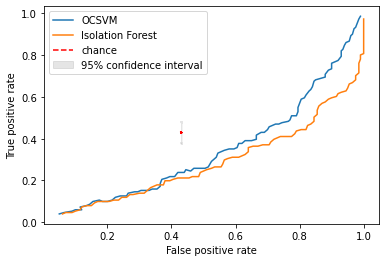

In [662]:
plt.subplot()
plt.plot(fp_list['oc'], tp_list['oc'], label='OCSVM')
plt.plot(fp_list['if'], tp_list['if'], label='Isolation Forest')

plt.plot(mean_random_fp, mean_random_tp, linestyle='--', label='chance', c='r')
#plt.plot(quantile_5_random_fp, quantile_5_random_tp, label='5th quantile')
#plt.plot(quantile_95_random_fp, quantile_95_random_tp, label='95th percentile')

plt.fill_between(mean_random_fp, quantile_5_random_tp, quantile_95_random_tp, color='grey', alpha=.2,
            label=f"95% confidence interval")


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

## Trajectories

In [79]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub', suffixes=('_200', '_500'))
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub', suffixes=('_700', '_1000'))
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [80]:
deletion_all.head()

,latent_200,loss_200,recon_200,input_200,sub,latent_500,loss_500,recon_500,input_500,latent_700,loss_700,recon_700,input_700,latent_1000,loss_1000,recon_1000,input_1000
0,"[-0.38987058, 1.814859, 0.6110011, 0.21380988,...",1881,1613,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,628248,"[-0.044629645, 1.3369011, -0.4782747, 0.305772...",2021,1752,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-0.6086889, -0.060489498, -0.0039648614, 0.52...",2489,2224,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-0.7531484, 0.8431534, 0.933035, -1.0674897, ...",2465,2194,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
1,"[-1.3145444, 0.2910724, 0.3596519, 1.2406789, ...",1828,1550,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,878877,"[-2.3361673, 0.6332646, -0.8050137, 1.9601942,...",1803,1512,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-1.5976859, 0.5088612, 0.62651557, -0.4510358...",2268,2002,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-1.5822557, 0.86050135, -0.121944055, -0.3983...",2519,2258,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
2,"[-0.7689903, -1.6160225, 0.5808759, -0.2395777...",2890,2598,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,329440,"[-0.373356, -2.3229465, -0.10135569, 1.2018762...",3029,2739,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-0.67647934, -0.9276844, 0.60801345, -0.90769...",3094,2797,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.20771417, -0.4633176, 1.1051017, -0.5104590...",3675,3410,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
3,"[1.062052, -0.4035468, -0.040406413, -1.608239...",1920,1656,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,453441,"[0.81158435, 0.1530474, -0.8546037, 0.19122915...",2092,1826,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.40803728, -1.013699, -0.42519957, -1.639501...",2440,2194,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.6916935, 0.06509067, 0.69490206, -1.391059,...",2632,2368,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
4,"[0.6155589, -1.6795915, 0.39211455, -0.9378491...",1753,1484,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,131722,"[-0.23466806, -1.0603116, -0.34790367, -0.6298...",1872,1596,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[-0.84548813, -0.97294533, 0.046896454, -1.632...",2592,2333,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,"[0.6891677, -1.8516729, 0.6179161, -1.1969818,...",2491,2206,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....


In [289]:
list_encoded_all = list(deletion_all['sub'])
df_encoded_all_X = deletion_all

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_all_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [89]:
X_del_all = np.array(list(df_encoded_all_X['latent_200']) + list(df_encoded_all_X['latent_500']) + list(df_encoded_all_X['latent_700']) + list(df_encoded_all_X['latent_1000']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_all_X['latent_200']) + list(df_encoded_all_X['latent_500']) + list(df_encoded_all_X['latent_700']) + list(df_encoded_all_X['latent_1000']))

labels_all =np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(10)] + ['500' for k in range(10)] + ['700' for k in range(10)] + ['1000' for k in range(10)])
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X_all)

In [513]:
X_all = np.array(list(df_encoded_hcp_X['latent']) + [df_encoded_all_X[k][0] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][1] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][2] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][3] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][4] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][5] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][6] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][7] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][8] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][9] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] )

labels_all = np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(10)] + ['500' for k in range(10)] + ['700' for k in range(10)] + ['1000' for k in range(10)])
reducer = umap.UMAP()
# embedding_all = reducer.fit_transform(X_all)
embedding_all = reducer.fit_transform(np.array(list(df_encoded_hcp_X['latent'])))

In [291]:
embedding_del = reducer.transform(X_del_all)

['1000' '200' '500' '700' 'hcp']
[220 221 222 223 224 225 226 227 228 229]
[190 191 192 193 194 195 196 197 198 199]
200
[200 201 202 203 204 205 206 207 208 209]
[210 211 212 213 214 215 216 217 218 219]


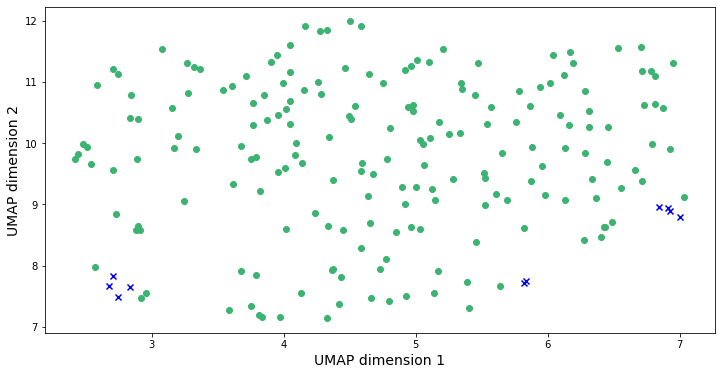

In [134]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure(figsize=(12,6))
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
    else:
        for i in ix:
            print(i)
            if 190 in i:
                print(g)
                ax.scatter(x, y, c=color_dict['sub1'], label = g_lab, marker=marker_dict[g])
            elif 191 in i:
                ax.scatter(x, y, c=color_dict['sub2'], label = g_lab, marker=marker_dict[g])
            elif 192 in i:
                ax.scatter(x, y, c=color_dict['sub3'], label = g_lab, marker=marker_dict[g])
            elif 193 in i:
                ax.scatter(x, y, c=color_dict['sub4'], label = g_lab, marker=marker_dict[g])
    
#plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

['1000' '200' '500' '700' 'hcp']


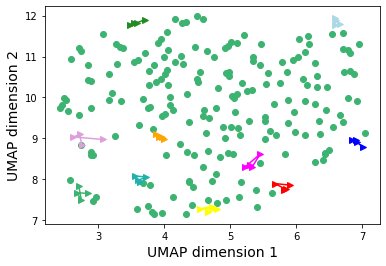

In [189]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure()
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][i][0] for i in range(4)], 
            [embedding_all[k:k+4][i][1] for i in range(4)], '->',c=list(color_dict.values())[idx])

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [294]:
embedding_del.shape

(40, 2)

['1000' '200' '500' '700' 'hcp']


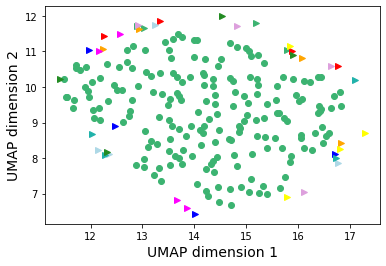

In [296]:
arr = np.array(list(embedding_all) + list(embedding_del))
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure()
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([arr[k:k+4][i][0] for i in range(4)], 
            [arr[k:k+4][i][1] for i in range(4)], '>',c=list(color_dict.values())[idx])

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

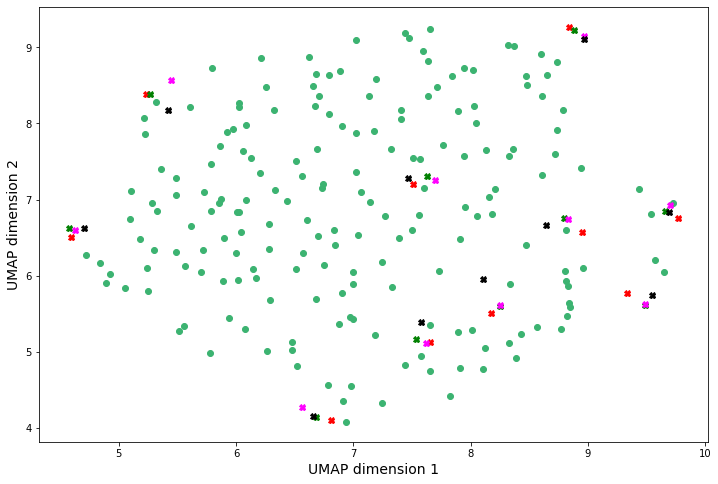

In [228]:
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X_all)

arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'black'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure(figsize=(12,8))
ax = fig.subplots()

for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
# for idx, k in enumerate(range(190, 227, 4)):
#     ax.plot([embedding_all[k:k+4][i][0] for i in range(0, 4, 1)], 
#             [embedding_all[k:k+4][i][1] for i in range(0, 4, 1)], '-->', c='magenta')
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][0][0]], 
            [embedding_all[k:k+4][0][1]], 'X', c='green')
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][1][0]], 
            [embedding_all[k:k+4][1][1]], 'X', c='magenta')
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][2][0]], 
            [embedding_all[k:k+4][2][1]], 'X', c='black')
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][3][0]], 
            [embedding_all[k:k+4][3][1]], 'X', c='red')

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Trajectory 200-1000

In [298]:
df_200_1000

,latent_200,loss_200,recon_200,input_200,sub,latent_1000,loss_1000,recon_1000,input_1000
0,"[-0.2905898, -0.013959071, -0.8990595, 0.04761...",2321,2031,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,887373,"[1.0376589, 0.97603214, 0.71130496, -0.8217206...",2767,2497,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
1,"[0.96034926, -0.5365658, -3.028193, 1.6349615,...",1759,1475,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,463040,"[1.1364107, -0.6994087, -1.4922446, -0.2872049...",2437,2167,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
2,"[0.9319158, -2.320161, 1.2870122, -1.3713944, ...",1733,1460,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,137431,"[-0.37107432, -2.0106165, 1.193153, -1.9291915...",3420,3174,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
3,"[0.70671856, -1.6163287, 1.6162556, 0.36796257...",1904,1622,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,203721,"[0.88102406, -1.7977341, 1.1382779, 0.02665004...",2531,2265,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
4,"[-0.6444578, 0.67964387, -0.4960109, 1.9705592...",2447,2170,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,802844,"[-0.9305126, -0.3653895, -1.2055594, 0.69715, ...",2950,2689,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
5,"[0.31185654, -0.36341026, 0.6696028, 0.3263350...",2016,1735,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,190031,"[-0.19770782, -0.75873595, 0.8541647, -0.86429...",2663,2402,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
6,"[0.47201747, 1.7895805, -2.046327, -1.2068485,...",2008,1736,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,186040,"[0.0041039027, 0.22494437, 0.17868397, -1.6989...",2839,2569,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
7,"[0.74711174, 0.61888677, 0.64987326, 0.8616992...",2222,1941,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,210112,"[-0.47188058, -0.25031614, 0.7847943, 0.390837...",2760,2506,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
8,"[-0.38987058, 1.814859, 0.6110011, 0.21380988,...",1881,1613,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,628248,"[-0.7531484, 0.8431534, 0.933035, -1.0674897, ...",2465,2194,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....
9,"[2.6438036, -0.7606913, -2.1411216, 0.27718657...",1816,1550,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....,601127,"[2.3098326, -0.9731301, -0.49097463, -1.728106...",2682,2422,[[[[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0....


In [300]:
df_200_1000 = pd.merge(deletion_200, deletion_1000, how='inner', on='sub', suffixes=('_200', '_1000'))

list_encoded_all = list(df_200_1000['sub'])[:200]
df_200_1000_X = df_200_1000

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_200_1000_X['sub'][:20].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X_all = np.array(list(df_encoded_hcp_X['latent']) + [df_200_1000[k][0] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][1] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][2] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][3] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][4] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][5] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][6] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][7] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][8] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][9] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][10] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][11] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][12] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][13] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][14] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][15] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][16] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][17] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][18] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][19] for k in ['latent_200', 'latent_1000']] )

labels_all = np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(20)] + ['1000' for k in range(20)])
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X_all)

In [309]:
len(list(df_encoded_hcp_X['Group']))

180

In [304]:
embedding_all.shape

(220, 2)

['1000' '200' 'hcp']


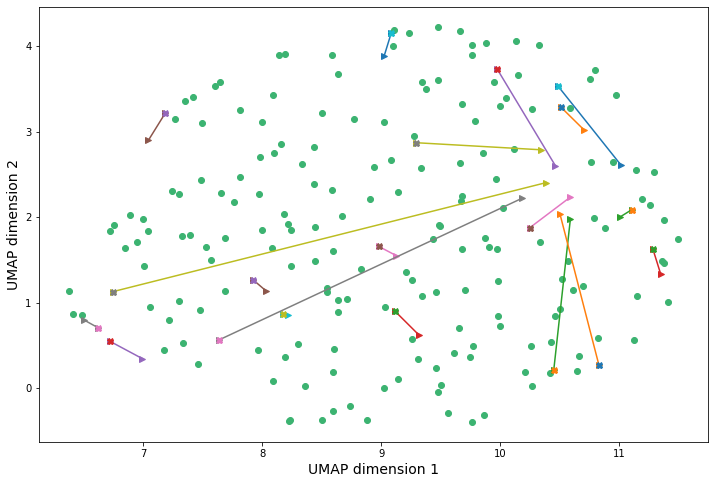

In [317]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure(figsize=(12,8))
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
for idx, k in enumerate(range(180, 217, 2)):
    ax.plot([embedding_all[k:k+2][i][0] for i in range(2)], 
            [embedding_all[k:k+2][i][1] for i in range(2)], '->')
for idx, k in enumerate(range(180, 217, 2)):
    ax.plot([embedding_all[k:k+2][0][0]], 
            [embedding_all[k:k+2][0][1]], 'X')

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Quantification

#### SS_size = 200

In [488]:
X_200 = np.array(list(df_encoded_200_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))

X = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_200_X['latent']))
label = np.array(['hcp' for k in range(len(X_hcp))] + ['200' for k in range(len(X_200))])

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, stratify=label, random_state=42)

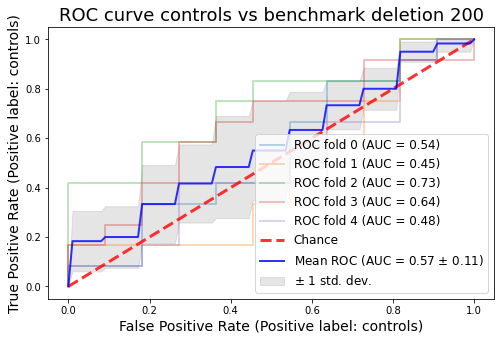

In [489]:
cv = StratifiedKFold(n_splits=5)
gb = LogisticRegression(random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 5))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    gb.fit(X_train[train], y_train[train])
    viz = metrics.plot_roc_curve(gb, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 200', fontsize=18)
plt.show()

In [490]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.564, est=0.526, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.513, est=0.558, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.590, est=0.539, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.658, est=0.561, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.447, est=0.587, cfg={'C': 0.7, 'penalty': 'l2'}
Accuracy: 0.554 (0.071)


>acc=0.564, est=0.526, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.513, est=0.558, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.590, est=0.539, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.658, est=0.561, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.447, est=0.587, cfg={'C': 0.7, 'penalty': 'l2'}


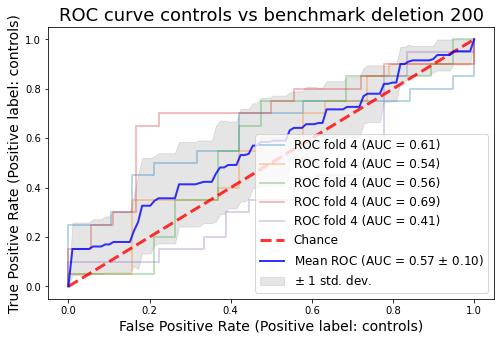

Accuracy: 0.554 (0.071)


In [491]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 200', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 500

In [495]:
df_encoded_500_X = deletion_500

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_500['sub'].astype(int))))
random_ctrl = random.sample(list_ctrl, 100)
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

X_500 = np.array(list(df_encoded_500_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_500_X['latent']))

#X_embedded_500 = TSNE(n_components=2).fit_transform(X_all)
label = np.array(list(df_encoded_hcp_X['Group']) + ['500' for k in range(len(df_encoded_500_X))])

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, stratify=label, random_state=42)

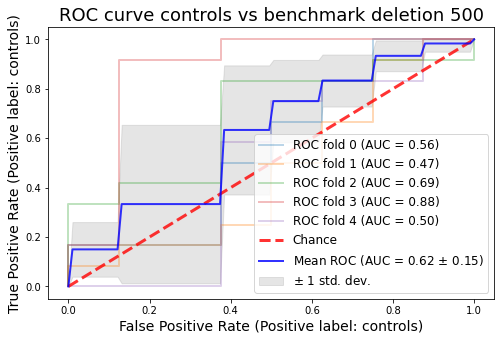

In [496]:
cv = StratifiedKFold(n_splits=5)
gb = LogisticRegression(random_state=12)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 5))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    gb.fit(X_train[train], y_train[train])
    viz = metrics.plot_roc_curve(gb, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 500', fontsize=18)
plt.show()

In [497]:
cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.794, est=0.619, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.647, est=0.582, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.529, est=0.582, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.576, est=0.630, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.606, est=0.659, cfg={'C': 1, 'penalty': 'l2'}
Accuracy: 0.630 (0.090)


>acc=0.794, est=0.619, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.647, est=0.582, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.529, est=0.582, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.576, est=0.630, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.606, est=0.659, cfg={'C': 1, 'penalty': 'l2'}


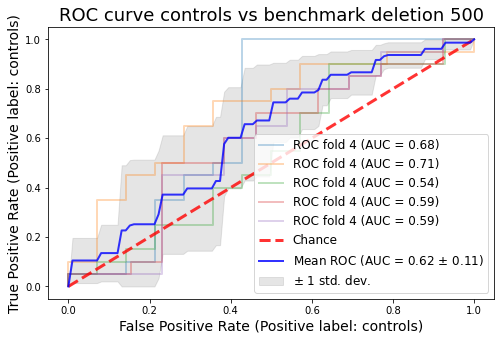

Accuracy: 0.630 (0.090)


In [498]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 500', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 700

In [499]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 100)
df_encoded_700_X = deletion_700[deletion_700['sub'].astype(int).isin(list_encoded_700)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_700_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X_700 = np.array(list(df_encoded_700_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_700_X['latent']))

#X_embedded_700 = TSNE(n_components=2).fit_transform(X_all)
label = np.array(list(df_encoded_hcp_X['Group']) + ['700' for k in range(len(df_encoded_700_X))])

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, stratify=label, random_state=42)

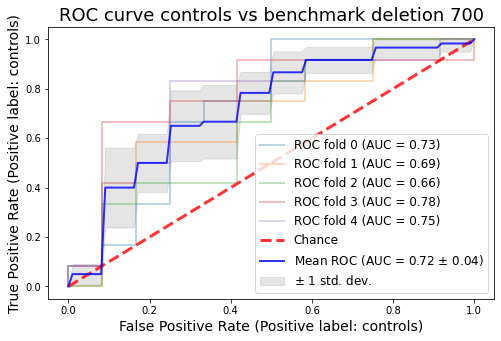

In [500]:
cv = StratifiedKFold(n_splits=5)
gb = LogisticRegression()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 5))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    gb.fit(X_train[train], y_train[train])
    viz = metrics.plot_roc_curve(gb, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 700', fontsize=18)
plt.show()

>acc=0.725, est=0.619, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.550, est=0.594, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.575, est=0.662, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.725, est=0.656, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.600, est=0.650, cfg={'C': 0.7, 'penalty': 'l2'}


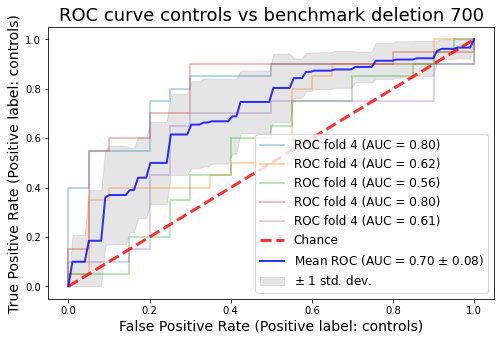

Accuracy: 0.635 (0.075)


In [501]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 700', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 1000

In [512]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 100)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].astype(int).isin(list_encoded_1000)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_1000_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X_1000 = np.array(list(df_encoded_1000_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_1000_X['latent']))

#X_embedded_1000 = TSNE(n_components=2, perplexity=15).fit_transform(X_all)
label = np.array(list(df_encoded_hcp_X['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.4, stratify=label, random_state=42)

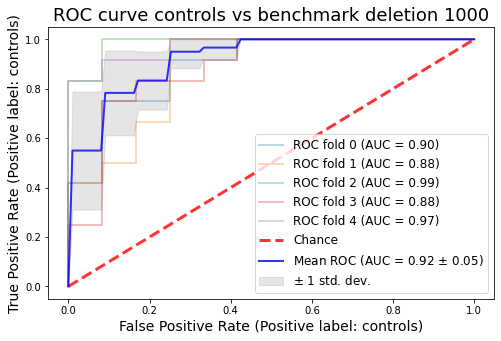

In [503]:
cv = StratifiedKFold(n_splits=5)
gb = GradientBoostingClassifier()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 5))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    gb.fit(X_train[train], y_train[train])
    viz = metrics.plot_roc_curve(gb, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 1000', fontsize=18)
plt.show()

>acc=0.800, est=0.925, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.900, est=0.887, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.850, est=0.900, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.875, est=0.850, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.850, est=0.875, cfg={'C': 0.7, 'penalty': 'l2'}


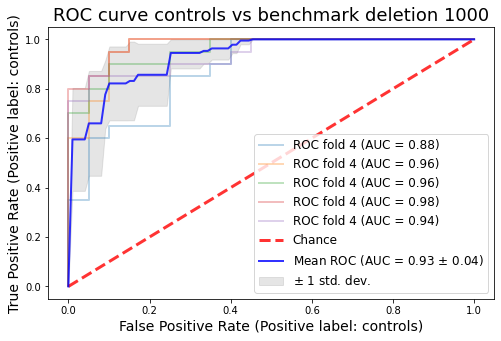

Accuracy: 0.855 (0.033)


In [504]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 1000', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

In [450]:
cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.850, est=0.944, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.925, est=0.931, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.850, est=0.950, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.950, est=0.912, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.900, est=0.894, cfg={'C': 0.7, 'penalty': 'l2'}
Accuracy: 0.895 (0.040)


In [509]:
logreg = LogisticRegression(random_state=0, max_iter=500)
logreg.fit(X_train, y_train)
print(logreg.score(X_test, y_test))
imp = logreg.coef_
imp_abs = list([abs(imp[0][k]) for k in range(len(imp[0]))])
imp_abs, names = zip(*sorted(list(zip(list(imp[0]), [k for k in range(len(imp_abs))]))))
print(imp_abs[-5:], names[-5:])

0.925
(0.47259548992939254, 0.49529111953054633, 0.5229202121515772, 0.6186860195496223, 0.7971726362967814) (33, 57, 46, 29, 9)


In [510]:
gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
print(gb.score(X_test, y_test))
imp = gb.feature_importances_
imp, names = zip(*sorted(list(zip(imp, [k for k in range(len(imp))]))))
print(imp[-5:], names[-5:])

0.775
(0.06014379354569805, 0.111560468653352, 0.13090743741798322, 0.20154989199562107, 0.24520685998180336) (38, 9, 2, 29, 68)


## Benchmark Asymmetry

In [263]:
data_dir = '/neurospin/dico/lguillon/distmap/benchmark/asymmetry/'

In [264]:
distmaps_asym = np.load(os.path.join(data_dir, "asym_benchmark_1mm.npy"),
                   mmap_mode='r')
filenames_asym = np.load(os.path.join(data_dir, "sub_id.npy"))

subset_asym = SkeletonDataset(dataframe=distmaps_asym,
                         filenames=filenames_asym,
                         data_transforms=False)
loader_asym = torch.utils.data.DataLoader(
               subset_asym,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [265]:
dico_set_loaders = {'asymmetry': loader_asym}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

criterion = nn.MSELoss(reduction='sum')
tester_asym = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_asym = tester_asym.test()
encoded_asym = {loader_name:[results_asym[loader_name][k][1] for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_asym = {loader_name:[int(results_asym[loader_name][k][0].cpu().detach().numpy()) for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_asym = {loader_name:[int(results_asym[loader_name][k][2].cpu().detach().numpy()) for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_asym = {loader_name:[results_asym[loader_name][k][3].cpu().detach().numpy() for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

asymmetry
[0.0000000e+00 7.4386597e-05 8.0347061e-05 ... 9.9866486e-01 9.9900138e-01
 9.9985051e-01]
[0.0000000e+00 6.6757202e-06 9.7751617e-06 ... 9.9760747e-01 9.9883580e-01
 9.9907076e-01]
[0.0000000e+00 9.0599060e-05 9.3936920e-05 ... 9.9952471e-01 9.9961555e-01
 9.9994659e-01]
[0.0000000e+00 8.5592270e-05 1.1754036e-04 ... 9.9909747e-01 9.9942851e-01
 9.9964750e-01]
[0.0000000e+00 4.2200089e-05 4.6730042e-05 ... 9.9815214e-01 9.9831235e-01
 9.9921489e-01]
[0.000000e+00 7.057190e-05 7.081032e-05 ... 9.992684e-01 9.994339e-01
 9.994767e-01]
[0.0000000e+00 5.1259995e-05 6.2942505e-05 ... 9.9898529e-01 9.9905300e-01
 9.9923515e-01]
[0.0000000e+00 2.3841858e-07 4.7683716e-07 ... 9.9946594e-01 9.9964213e-01
 9.9992526e-01]
[0.0000000e+00 2.1934509e-05 2.5749207e-05 ... 9.9798131e-01 9.9864352e-01
 9.9990916e-01]
[0.0000000e+00 9.0122223e-05 9.6797943e-05 ... 9.9835503e-01 9.9870765e-01
 9.9986112e-01]
[0.0000000e+00 1.5711784e-04 1.5950203e-04 ... 9.9754870e-01 9.9932742e-01
 9.9953532e

[0.0000000e+00 7.1525574e-06 7.6293945e-06 ... 9.9916685e-01 9.9972224e-01
 9.9973297e-01]
[0.0000000e+00 2.4557114e-05 2.5510788e-05 ... 9.9945533e-01 9.9948728e-01
 9.9988425e-01]
[0.0000000e+00 1.0728836e-05 1.4543533e-05 ... 9.9929500e-01 9.9955666e-01
 9.9986649e-01]
[0.0000000e+00 3.5762787e-06 4.0531158e-06 ... 9.9884474e-01 9.9900663e-01
 9.9948204e-01]
[0.0000000e+00 2.5033951e-05 2.5749207e-05 ... 9.9965286e-01 9.9975431e-01
 9.9989319e-01]
[0.00000000e+00 1.11579895e-04 1.28030777e-04 ... 9.99215484e-01
 9.99647498e-01 9.99679565e-01]
[0.0000000e+00 3.0755997e-05 5.8650970e-05 ... 9.9744844e-01 9.9788880e-01
 9.9965823e-01]
[0.0000000e+00 8.3446503e-05 9.1314316e-05 ... 9.9947131e-01 9.9977040e-01
 9.9989319e-01]
[0.0000000e+00 4.7445297e-05 6.7472458e-05 ... 9.9930573e-01 9.9950337e-01
 9.9995720e-01]
[0.0000000e+00 1.2636185e-05 1.7166138e-05 ... 9.9840856e-01 9.9919438e-01
 9.9980772e-01]
[0.0000000e+00 1.2731552e-04 1.2755394e-04 ... 9.9690247e-01 9.9845123e-01
 9.986863

[0.0000000e+00 3.6716461e-05 4.0292740e-05 ... 9.9884260e-01 9.9983954e-01
 9.9995112e-01]
[0.0000000e+00 3.6478043e-05 4.1961670e-05 ... 9.9806678e-01 9.9889982e-01
 9.9951398e-01]
[0.0000000e+00 1.1920929e-06 1.4305115e-06 ... 9.9887848e-01 9.9944460e-01
 9.9965823e-01]
[0.0000000e+00 2.1314621e-04 2.4342537e-04 ... 9.9961555e-01 9.9975967e-01
 9.9981749e-01]
[0.0000000e+00 4.4107437e-05 4.4822693e-05 ... 9.9839783e-01 9.9856877e-01
 9.9925363e-01]
[0.0000000e+00 3.5285950e-05 4.6491623e-05 ... 9.9988246e-01 9.9993587e-01
 9.9995196e-01]
[0.0000000e+00 5.1259995e-05 5.5789948e-05 ... 9.9913490e-01 9.9936986e-01
 9.9980772e-01]
[0.0000000e+00 8.6545944e-05 9.6321106e-05 ... 9.9824822e-01 9.9888921e-01
 9.9967957e-01]
[0.0000000e+00 6.1035156e-05 6.1273575e-05 ... 9.9962080e-01 9.9967957e-01
 9.9987185e-01]
[0.0000000e+00 8.1777573e-05 8.4877014e-05 ... 9.9870372e-01 9.9929047e-01
 9.9942327e-01]
[0.0000000e+00 6.8426132e-05 7.3671341e-05 ... 9.9960482e-01 9.9961019e-01
 9.9992526e-01]

In [266]:
df_encoded_asym = pd.DataFrame()
df_encoded_asym['latent'] = encoded_asym['asymmetry']
df_encoded_asym['loss'] = losses_asym['asymmetry']  
df_encoded_asym['recon'] = recon_asym['asymmetry']   
df_encoded_asym['input'] = input_asym['asymmetry'] 
df_encoded_asym['sub'] = list(filenames_asym) 

In [267]:
data_dir = "/neurospin/dico/lguillon/distmap/analyses_gridsearch/75_2/"
df_encoded_hcp = pd.read_pickle(os.path.join(data_dir, "encoded_hcp.pkl"))[:200]

In [268]:
X_asym = np.array(list(df_encoded_asym['latent']))
X_hcp = np.array(list(df_encoded_hcp['latent']))
X_all = np.array(list(df_encoded_hcp['latent']) + list(df_encoded_asym['latent']))

labels_asym = np.array(list(df_encoded_hcp['Group']) + ['asymmetry' for k in range(len(df_encoded_asym))])
reducer = umap.UMAP(random_state=14)
embedding_asym = reducer.fit_transform(X_all)

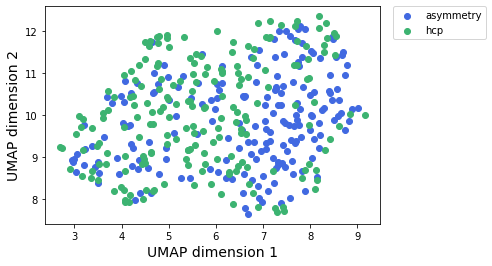

In [577]:
arr = embedding_asym
color_dict = {'hcp':'mediumseagreen', 'asymmetry': 'royalblue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_asym):
    ix = np.where(labels_asym == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

>acc=0.797, est=0.785, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.759, est=0.763, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.759, est=0.763, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.785, est=0.781, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.848, est=0.775, cfg={'C': 0.7, 'penalty': 'l2'}


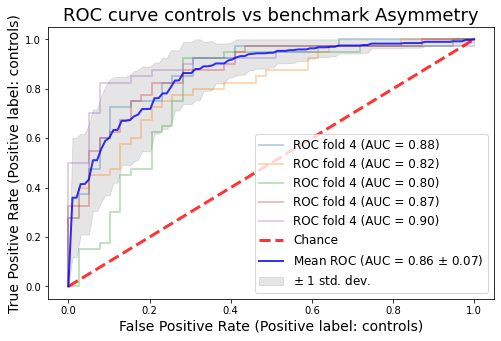

Accuracy: 0.790 (0.033)


In [591]:
X_train, X_test, y_train, y_test = train_test_split(X_all, labels_asym, test_size=0.4, stratify=labels_asym, random_state=42)

fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X_all, labels_asym):
    X_train, X_test = X_all[train_ix, :], X_all[test_ix, :]
    y_train, y_test = labels_asym[train_ix], labels_asym[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark Asymmetry', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

In [579]:
imp = best_model.coef_
imp_abs = list([abs(imp[0][k]) for k in range(len(imp[0]))])
imp_abs, names = zip(*sorted(list(zip(list(imp[0]), [k for k in range(len(imp_abs))]))))
print(imp_abs[-5:], names[-5:])

(0.5292654887873073, 0.5546583542644274, 0.6137770044744678, 0.6543227671742893, 0.6840168078392206) (37, 48, 8, 21, 47)


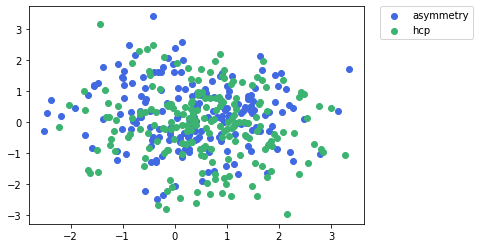

In [585]:
color_dict = {'hcp': 'mediumseagreen', 'asymmetry': 'royalblue'}
most_imp = [47, 2]
arr = np.array([np.array([X_all[i][k] for k in most_imp]) for i in range(len(X_all))])

fig = plt.figure()
ax = fig.add_subplot(111)

for g in np.unique(labels_asym):
    #if g == 'HCP' or g == 'leftHanders':
    ix = np.where(labels_asym == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    #ax.scatter(arr[ix][0], arr[ix][1], arr[ix][2], c = color_dict[g], label = g)
    g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
#ax.legend(fontsize=14)
plt.show()

## Folding space - loss distributions

In [50]:
len(df_encoded_deletion)

507

In [51]:
len(df_encoded_200_X)

93

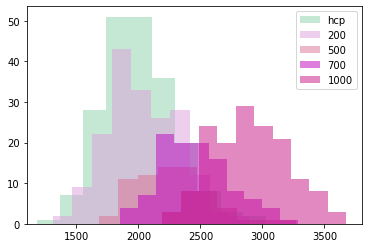

In [74]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='200'].loss, color='plum', alpha=0.5, label='200')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='500'].loss, color='palevioletred', alpha=0.5, label='500')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='700'].loss, color='m', alpha=0.5, label='700') 
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='1000'].loss, color='mediumvioletred', alpha=0.5, label='1000')
plt.legend()

In [83]:
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='200'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='500'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='700'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='1000'].loss)
print(p)

0.13405716752885355
8.063715007845529e-10
1.5333475604152505e-26
2.882310954362431e-54


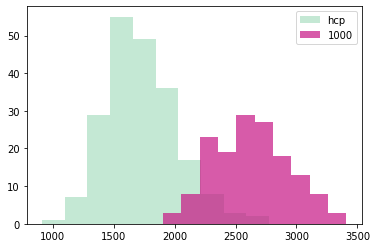

In [81]:
plt.subplot()
plt.hist(df_encoded_hcp.recon, color='mediumseagreen', alpha=0.3, label='hcp')
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='200'].recon, color='plum', alpha=0.5, label='200')
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='500'].recon, color='palevioletred', alpha=0.7, label='500')
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='700'].recon, color='m', alpha=0.5, label='700') 
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='1000'].recon, color='mediumvioletred', alpha=0.7, label='1000')
plt.legend()

In [116]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 100)
df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(list_encoded_200)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_200_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

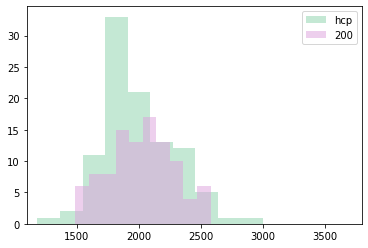

In [117]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_200_X.loss, color='plum', alpha=0.5, label='200')
plt.legend()

In [118]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_200_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_200_X.loss)
print(p)

0.20967579320349722
0.26055273160812736


In [119]:
df_encoded_500_X = deletion_500

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_500['sub'].astype(int))))
random_ctrl = random.sample(list_ctrl, 100)
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

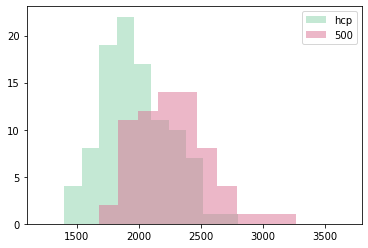

In [120]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_500_X.loss, color='palevioletred', alpha=0.5, label='500')
plt.legend()

In [121]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_500_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_500_X.loss)
print(p)

1.0737435822935459e-09
1.1089679835628955e-07


In [122]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 100)
df_encoded_700_X = deletion_700[deletion_700['sub'].astype(int).isin(list_encoded_700)]
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_700_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

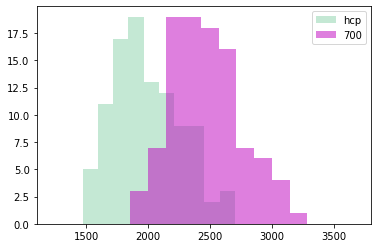

In [123]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_700_X.loss, color='m', alpha=0.5, label='700') 
plt.legend()

In [124]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_700_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_700_X.loss)
print(p)

2.706751769689624e-20
3.2764005184650757e-17


In [125]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 100)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].astype(int).isin(list_encoded_1000)]
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_1000_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

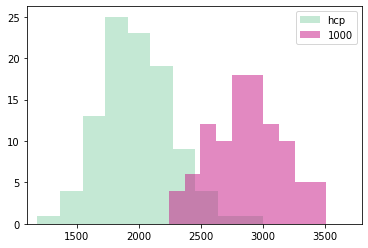

In [126]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_1000_X.loss, color='mediumvioletred', alpha=0.5, label='1000') 
plt.legend()

In [127]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_1000_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_1000_X.loss)
print(p)

3.674315979879044e-32
5.774179148531572e-37


In [128]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub', suffixes=('_200', '_500'))
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub', suffixes=('_700', '_1000'))
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [130]:
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_all['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [262]:
# plt.subplot()
# plt.xlim([1100, 3800])
# plt.hist(df_encoded_hcp_X[:50].loss, color='mediumseagreen', alpha=0.3, label='hcp')
# # plt.scatter(deletion_all.loss_200[:1], [1], color='plum', alpha=0.8, label='200') 
# # plt.scatter(deletion_all.loss_500[:1], [1], color='palevioletred', alpha=0.8, label='500') 
# # plt.scatter(deletion_all.loss_700[:1], [1], color='m', alpha=0.8, label='700') 
# # plt.scatter(deletion_all.loss_1000[:1], [1], color='mediumvioletred', alpha=0.8, label='1000') 

# plt.scatter(deletion_all.loss_200[1], [2], color='plum', alpha=0.8, label='200', marker='o') 
# plt.scatter(deletion_all.loss_500[1], [2], color='palevioletred', alpha=0.8, label='500', marker='o') 
# plt.scatter(deletion_all.loss_700[1], [2], color='m', alpha=0.8, label='700', marker='o') 
# plt.scatter(deletion_all.loss_1000[1], [2], color='mediumvioletred', alpha=0.8, label='1000', marker='o') 

# plt.plot(deletion_all.loss_200[2], [2], color='plum', alpha=0.8, label='200', marker='->') 
# plt.scatter(deletion_all.loss_500[2], [2], color='palevioletred', alpha=0.8, label='500', marker='->') 
# plt.scatter(deletion_all.loss_700[2], [2], color='m', alpha=0.8, label='700', marker='->') 
# plt.scatter(deletion_all.loss_1000[2], [2], color='mediumvioletred', alpha=0.8, label='1000', marker='->') 

# # plt.scatter(deletion_all.loss_200[3], [3], color='plum', alpha=0.8, label='200', marker='X') 
# # plt.scatter(deletion_all.loss_500[3], [3], color='palevioletred', alpha=0.8, label='500', marker='X') 
# # plt.scatter(deletion_all.loss_700[3], [3], color='m', alpha=0.8, label='700', marker='X') 
# # plt.scatter(deletion_all.loss_1000[3], [3], color='mediumvioletred', alpha=0.8, label='1000', marker='X') 

# # plt.hist(deletion_all.loss_700, color='m', alpha=0.5, label='700') 
# # plt.hist(deletion_all.loss_1000, color='mediumvioletred', alpha=0.5, label='1000') 


# # plt.plot(np.histogram(list(deletion_all.loss_200))[1][:-1],np.histogram(list(deletion_all.loss_200))[0], color='plum', alpha=0.8, label='200') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_500))[1][:-1],np.histogram(list(deletion_all.loss_500))[0], color='palevioletred', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_700))[1][:-1],np.histogram(list(deletion_all.loss_700))[0], color='m', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_1000))[1][:-1],np.histogram(list(deletion_all.loss_1000))[0], color='mediumvioletred', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 

# plt.legend()

In [261]:
delta_loss_200, delta_loss_500, delta_loss_700, delta_loss_1000 = [], [], [], []
for k in range(len(deletion_all)):
    sub = deletion_all['sub'][k]
    delta = (deletion_all['loss_200'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].loss.values)[0]
    delta_loss_200.append(delta)
    
    delta = (deletion_all['loss_500'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].loss.values)[0]
    delta_loss_500.append(delta)
    
    delta = (deletion_all['loss_700'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].loss.values)[0]
    delta_loss_700.append(delta)
    
    delta = (deletion_all['loss_1000'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==int(sub)].loss.values)[0]
    delta_loss_1000.append(delta)

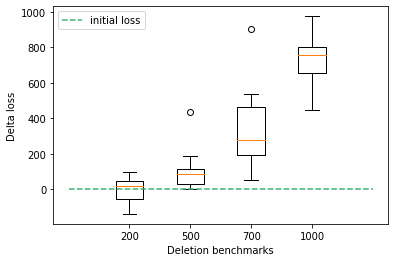

In [260]:
plt.boxplot((delta_loss_200, delta_loss_500, delta_loss_700, delta_loss_1000),
            labels=('200','500','700','1000'))
plt.plot(['0','200','500','700','1000', '2000'], [0, 0, 0, 0, 0, 0], color='mediumseagreen', ls='--',
        label='initial loss')
plt.xlabel('Deletion benchmarks')
plt.ylabel('Delta loss')
plt.legend()

### Asymmetry

In [269]:
list_encoded_asym = random.sample(list(df_encoded_asym['sub']), 100)
df_encoded_asym_X = df_encoded_asym[df_encoded_asym['sub'].astype(int).isin(list_encoded_asym)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_asym_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

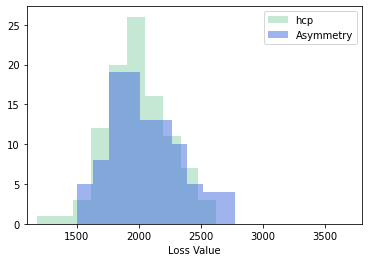

In [272]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_asym_X.loss, color='royalblue', alpha=0.5, label='Asymmetry') 
plt.xlabel('Loss Value')
plt.legend()

In [273]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_asym_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_asym_X.loss)
print(p)

0.14839642982370554
0.34388571222170217
